## Introduction

In this notebook, we will solve for the vorticity evolution of the 2-d Navier-Stokes equation for viscous, incompressible fluid in vorticity form using a DeepONet. The branch consist of a UNet whose input is the initial condition, while the trunk's input are the spatial and temporal dimensions.

Data information can be obtained from https://github.com/oduolaidrisA/Scientific-Machine-Learning/blob/main/data_generation.ipynb. From the data, there are 100 time snapshots of the vorticity evolution in $[0,50]$. The spatial domain considered is $(0,1)^2$ with 256 steps each in the $x$ and $y$ axis. Feeding these in a trunk-net with a feed-forward neural network implies there are $256 \times 256 \times 100 = 6,553,600$ points to be fed into the trunk. This is extremely huge and will be computationally expensive to process.

A solution will be to use a separable deeponet $[1]$, where the trunk-net is a separable neural network. This basically means that instead of using a single feed-forward neural network in the trunk for the multi-dimensional coordinates, we can employ factorized coordinates and separate sub-networks for each on-dimensional domain. This means that for our problem the trunk consists of 3 sub-networks for the $x$, $y$ and $t$ domain. Thus, the total trunk input becomes $256+256+100 = 612$ points, which is ~$10,000 $ times decrease in the input. Thus, much more computationally efficient. It is important to note that this approach can only be utilized if the domain is separable, like the rectangular domain we have.

Another approach is to include the spatial coordinates as channels in the branch input. This approach was used in $[2]$, where they utilized DeepONet for C02 sequestration. This means that the trunk input now consist of only the time-domain $t$, so the input to the trunk in our case is just $100$ points, which is ~$65,000$ decrease from the initial input we had. However, this approach will only work if the domain is separable and the inputs and outputs of the deepONet are of the same dimensions.

For this notebook, we will utilize the second approach since we are solving for the vorticity evolution (which means the inputs and outputs are of same dimension).

In [28]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from sklearn.model_selection import train_test_split
torch.set_float32_matmul_precision('high') # or'high'. This is to properly utilize Tensor Cores of my CUDA device ('NVIDIA RTX A6000')
import h5py

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Seed set to 42


cuda


In [97]:
class config:
    def __init__(self):
        #The File paths
        self.data_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/ns_data.h5' #Load data 
        self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/ns_model_deep.pt'
        self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_ns'


        #Model Parameters
        self.lift_channel = 50
        self.base_channel = 64
        self.output_p = 32
        self.layers = 5 

        
        #Optimizer
        self.lr = 0.001
        self.weight_decay = 1e-4 #Regularization weight
        
        #The training parameters
        self.num_epoch = 100
        self.batch_size = 20

        #Learning rate scheduler
        self.step_size = 20  #To decay after every, say 10 epochs
        self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

        

cfg = config()

#### Data Preparation

In [30]:
with h5py.File(cfg.data_path, 'r') as file:
    w_evolution = np.array(file['u'])

In [67]:
def input_dim(data):
    """
    A function to include the spatial dimensions

    """
    B,H,W,T = data.shape
    #The Spatial coordinates
    x_coords = torch.linspace(0,1, steps = W).view(1,-1).expand(H,W) #(256,256)
    y_coords = torch.linspace(0,1, steps = H).view(-1,1).expand(H,W) #(256,256)
    #Stacking the coordinates
    coord_stack = torch.tensor(np.stack([x_coords,y_coords], axis = -1)).float() #(256,256,2)
    coord_stack = coord_stack.unsqueeze(0).unsqueeze(3) # (1,256,256,1,2)
    coord_stack= coord_stack.repeat(B,1,1,T,1)
    #Now we concatenate the data with the information on the spatial dimension
    data1 = data.unsqueeze(-1) # (B,256,256,T, 1)
    new_data = torch.cat([data1, coord_stack], dim = -1) # (B,256,256,T,3)
    assert new_data.shape[-1] == 3, print(f"Loaded input variables successfully. Data now has size {new_data.shape}")
    return new_data


In [68]:
w_evolution.shape

(500, 256, 256, 100)

In [69]:
def prepare_data(data,cfg):
    """
    Prepares the train, val and test data
    
    """
    data = torch.tensor(data) #Make data a torch tensor

    #Normalization
    #data = (data - data.mean())/(data.std() + 1e-8) #The small value added is to avoid division by zero

    new_data = input_dim(data)
    print(f"Target is of Shape:{data.shape}")

    #Branch input
    branch_input = new_data[:,:,:,0,:] #initial vorticity --> (B,256,256,3)
    print(f"Branch input is of Shape:{branch_input.shape}")
    training_points = data.shape[0]
    dataset = TensorDataset(branch_input, data)
    train_set, val_set, test_set = random_split(dataset, [training_points - 100, 50, 50])

    #DataLoader
    train_loader = DataLoader(train_set, batch_size = cfg.batch_size, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = cfg.batch_size, shuffle = False)
    test_loader = DataLoader(test_set, batch_size = cfg.batch_size, shuffle = False)

    return train_loader, val_loader, test_loader

In [70]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        self.train_loader, self.val_loader, self.test_loader= prepare_data(w_evolution,self.cfg)
        print('DataLoaded Successfully!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)
data_module.setup()

Target is of Shape:torch.Size([500, 256, 256, 100])
Branch input is of Shape:torch.Size([500, 256, 256, 3])
DataLoaded Successfully!


In [71]:
batch = next(iter(data_module.test_dataloader()))
w_init, w_fin = batch
print("Initial Vorticity batch shape:", w_init.shape)
print("Final Vorticities batch shape:", w_fin.shape)

print(w_init.max(), w_init.min())
print(w_fin.max(), w_fin.min())

Initial Vorticity batch shape: torch.Size([20, 256, 256, 3])
Final Vorticities batch shape: torch.Size([20, 256, 256, 100])
tensor(10.0779) tensor(-8.3737)
tensor(10.0779) tensor(-8.3737)


#### The DeepONet

> As indicated earlier, we will use a UNet in the branch. However, it is important to note that any suitable network can be used in the branch

##### The UNet
We adopt similar UNet structure as in https://github.com/oduolaidrisA/Scientific-Machine-Learning/blob/main/unet_for_scientific_computing.ipynb.

In [72]:
#We will be defining the convolutional block
#This block will contain n_conv number of convolution layers, whose final layer downsamples the image resolution by 2 using strides
class conv_blocks(nn.Module):
    def __init__(self, in_channels, out_channels, stride, n_conv = 3, mid_channels = None):
        """
        n_conv*(conv --> batchnorm --> LeakyReLU)
        """
        super().__init__()
        mid_channels = mid_channels or out_channels
        def conv_block(in_ch, out_ch, strd):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=strd, padding = 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(inplace = True)
            )
        layers = [conv_block(in_channels, mid_channels, 1)]
        layers += [conv_block(mid_channels, mid_channels, 1) for _ in range(n_conv -2)]
        layers += [conv_block(mid_channels, out_channels, stride)]
        self.block = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.block(x)

In [73]:
#Now we define upsampling layer in the UNet.
#upsampling is done using convTranspose
#There is a number of convolution layers before each upsampling and the bottleneck.
class up_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(inplace = True)
        )
        def conv_block(in_ch, out_ch, strd):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=strd, padding = 1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(inplace = True)
            )
        layers = []
        layers += [conv_block(in_channels, in_channels, 1) for _ in range(2)] #
        self.conv = nn.Sequential(*layers)
        

    def forward(self, x1, x2): #x2 is the skip connection from the encoder
        x1 = self.conv(x1)
        x1 = self.up(x1)
        
        #We need to add paddings to match x2 if needed
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        
        return x

In [99]:
class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.base_channel = cfg.base_channel
        self.in_channel = cfg.lift_channel #Initial input channels coming from the lifting layer
        self.out_channel = cfg.output_p #Final output channel

        #The encoder block contains 3 conv blocks, we increase the number of channels by 2 as we downsize 
        self.encoder_block = nn.ModuleList([
            conv_blocks(self.in_channel, self.base_channel, stride = 2, n_conv = 3, mid_channels = self.base_channel), #Output shape (n, f,128,128)
            conv_blocks(self.base_channel, 2*self.base_channel, stride = 2, n_conv = 3), #Output shape (n, 2f,64,64)
            conv_blocks(2*self.base_channel, 4*self.base_channel, stride = 2, n_conv = 3, mid_channels = 2*self.base_channel) #Output shape (n, 4f,32,32)
        ])
        
        #The decoder block (There are 3 blocks here)
        self.decoder_block = nn.ModuleList([
            up_layer(4*self.base_channel, 2*self.base_channel), #Output shape (n, 4f,64,64)
            up_layer(4*self.base_channel, self.base_channel), #Output shape (n, 2f, 128, 128)
            up_layer(2*self.base_channel, self.in_channel) #Output shape (n, f, 256, 256)
        ])
    
        #The final output convolution
        self.final_conv = conv_blocks(2*self.in_channel, self.out_channel, stride = 1, n_conv = 3, mid_channels = self.base_channel) #Output shape (n, p, 256, 256)
        self.activation = nn.Tanh()

    def forward(self, x):
        #print(f"Initial x is of shape {x.shape}")
        res = []
    
        for i, down in enumerate(self.encoder_block): 
            res.append(x)
            x = down(x)
            #print(f"During downsampling, x{i} is of shape {x.shape}")
    
        for i, up in enumerate(self.decoder_block):
            x2 = res.pop()
            x = up(x, x2)
            #print(f"During upsampling, x{i} is of shape {x.shape}")
        x = self.final_conv(x)
        #print(f"x final is of shape {x.shape}")
        return x #self.activation(x)

In [100]:
#Visualizing the UNet outputs, uncomment the print functions in the unet class
#sample = torch.randn(1,cfg.lift_channel,256,256)
#mynet = UNet(cfg)
#x = mynet(sample)

#### Branch and Trunk Nets

In [101]:
#first we define the branch net
#The branch net will contain a lifting layer, a UNet, and a branch and trunk multiplication
class branch_net(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.lift = nn.Conv2d(in_channels = 3, out_channels = cfg.lift_channel, kernel_size = 1) #The Lift layer
        self.unet = UNet(cfg)

    def forward(self,x):
        assert x.shape[1:] == (256,256,3), f"Unexpected input shape: {x.shape}"
        x = x.permute(0,3,1,2) #Move the channels to have (batch, 3, 256,256)
        x = self.lift(x) #Linear lifting layer --> (batch, f, 256,256)
        #The UNet
        x = self.unet(x) #UNet including the projection --> (batch, p, 256,256)

        x = x.permute(0,2,3,1) # reorder for DeepOnet einsum product --> (batch, 256,256, p)
        return x

In [102]:
#Now we define the Trunk net
#Preparing data
cfg.t_grid = torch.linspace(0,50,100).view(-1,1)
#Normalization
t_mean, t_std = cfg.t_grid.mean(), cfg.t_grid.std()
cfg.t_grid = (cfg.t_grid - t_mean) / (t_std + 1e-6)
class trunk_net(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.ReLU()
        self.out = cfg.output_p
        self.hidden_dim = cfg.base_channel
        self.layers = cfg.layers

        #Defining the layers
        self.linears = nn.ModuleList()

        self.linears.append(nn.Linear(1, self.hidden_dim))
        for _ in range(self.layers - 2):
            self.linears.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.linears.append(nn.Linear(self.hidden_dim, self.out)) #Output is (100,p)

    def forward(self,t):
        a = t.float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

#### Putting all together

In [103]:
class navier_deeponet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.branch = branch_net(cfg)
        self.trunk = trunk_net(cfg)
        self.cfg = cfg

    def forward(self,x):
        """
        Inputs
        x: shape (batch, 256,256,3)
        t: (100, 1)

        Output: (batch, 256,256,100)
        
        """
        t = self.cfg.t_grid.to(x.device)

        #The branch net: (batch, 256,256,3) --> (batch, 256,256,p)
        B_out = self.branch(x)

        #The Trunk net: (100,1) --> (100,p)
        T_out = self.trunk(t)

        #Final output
        output = torch.einsum("abcd, ed -> abce",B_out,T_out) # (batch,256,256,100)

        #We can add linear projection layers if we wish

        return output
        

### Training

In [104]:
#Initializing the model parameters
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [105]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = navier_deeponet(self.cfg)
        self.model.apply(init_weights)
        self.metrics = {'train_loss':[], 'val_loss':[]}
        

    def forward(self,x):
        return self.model(x)

    def loss_function(self,y_true,y_hat, beta = 0.5):

        #A gradient loss is added to capture possible edges
        grad_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_true_y = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]

        grad_pred_x = y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]
        grad_pred_y = y_hat[:, 1:, :, :] - y_hat[:, :-1, :, :]

        direct_loss = F.mse_loss(y_hat, y_true)
        return  direct_loss + beta*(F.mse_loss(grad_true_x, grad_pred_x) + F.mse_loss(grad_true_y, grad_pred_y))
        
    def _common_step(self, batch):
        x,y = batch
        y_hat = self(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = self.loss_function(y,y_hat, beta = 0.5)
        return loss

    def training_step(self, batch):
        loss = self._common_step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch):
        loss = self._common_step(batch)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch):
        x,y = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]



    def evaluate_on_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                predictions.append(y_hat.cpu())
                targets.append(y.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = self.loss_function(y,y_hat, beta = 0.5)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        seis_hat = torch.cat(predictions,dim =0); seis_true = torch.cat(targets,dim =0)
        print(f"Average Loss on exact test set: {avg_loss:.4f}")
        return avg_loss, seis_hat, seis_true        

In [106]:
model = PlModel(cfg)

In [107]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'ns_deeponet-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    log_every_n_steps = 20,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\checkpoint_ns exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | navier_deeponet | 4.7 M  | train
--------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.959    Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode


Target is of Shape:torch.Size([500, 256, 256, 100])
Branch input is of Shape:torch.Size([500, 256, 256, 3])
DataLoaded Successfully!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


#### Evaluation

In [108]:
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("ns_deeponet-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(
    checkpoint_path,
    cfg=cfg 
)

pred_loader = data_module.test_dataloader()

In [113]:
avgloss, preds, exact = model.evaluate_on_test_set(pred_loader)
preds = preds.permute(0,3,1,2)
exact = exact.permute(0,3,1,2)

Average Loss on exact test set: 0.1289


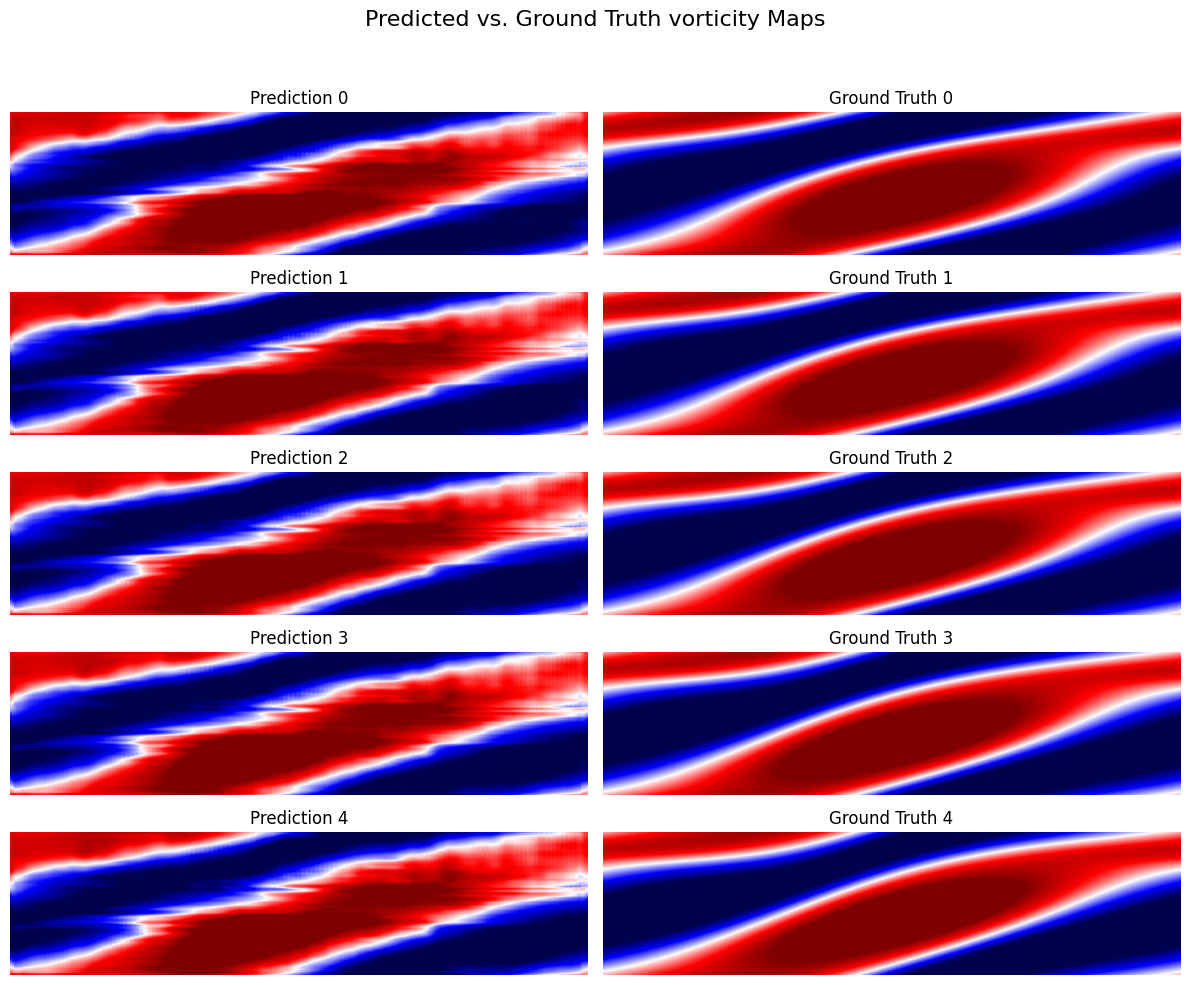

In [116]:
%matplotlib inline
plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Ground Truth vorticity Maps", fontsize=16)
n = 3
for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[n, 30+i, :, :], aspect='auto', cmap='seismic', vmin=-1, vmax=1)
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[n, 30+i, :, :], aspect='auto', cmap='seismic', vmin=-1, vmax=1)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [120]:
#Animated Visualization for a sample in time
%matplotlib qt

sample_idx = 0

u_pred = preds[sample_idx]    # Shape: (100, H, W)
u_exact = exact[sample_idx]   # Shape: (100, H, W)

# side-by-side figure setup
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im_pred = axs[0].imshow(u_pred[0], cmap='seismic', vmin=-1, vmax=1)
im_exact = axs[1].imshow(u_exact[0], cmap='seismic', vmin=-1, vmax=1)

axs[0].set_title("Prediction at time step 0")
axs[1].set_title("Exact at time step 0")

#fig.colorbar(im_pred, ax=axs[0])
fig.colorbar(im_exact, ax=axs[1])

# Animation loop
for i in range(u_pred.shape[0]):
    im_pred.set_data(u_pred[i])
    im_exact.set_data(u_exact[i])
    axs[0].set_title(f"Prediction at time step {i}")
    axs[1].set_title(f"Exact at time step {i}")
    plt.pause(0.05)

plt.show()


### References

[1] Mandl, L., Goswami, S., Lambers, L., & Ricken, T. (2025). *Separable physics-informed DeepONet: Breaking the curse of dimensionality in physics-informed machine learning*. Computer Methods in Applied Mechanics and Engineering, 434, 117586.

[2] Diab, W., & Al Kobaisi, M. (2024). *U-DeepONet: U-Net enhanced deep operator network for geologic carbon sequestration*. Scientific Reports, 14(1), 21298.
